<a href="https://colab.research.google.com/github/ZitongZhou/react_inverse/blob/master/CAAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import argparse
import os
import numpy as np
import math
import itertools
import sys
import pickle as pk
import time
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, MultiStepLR

import torch.nn as nn
import torch.nn.functional as F
import torch
import h5py
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from google.colab import drive
from google.colab import files
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


# CAAE 3d models

## model definition part

In [2]:
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    eps = torch.randn_like(std)
    #randn_like: Returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.
    #return: random gaussian sample from distribution with mu and exp(logvar/2)
    return mu + eps*std


class DenseResidualBlock(nn.Module):
    """
    The core module of paper: (Residual Dense Network for Image Super-Resolution, CVPR 18)
    """

    def __init__(self, filters, res_scale=0.2):
        super(DenseResidualBlock, self).__init__()
        self.res_scale = res_scale

        def block(in_features, non_linearity=True):
            layers = [nn.BatchNorm3d(in_features)]
            layers += [nn.ReLU(inplace=True)]
            layers += [nn.Conv3d(in_features, filters, 3, 1, 1, bias=True)] # does not change state size
            return nn.Sequential(*layers)

        self.b1 = block(in_features=1 * filters)
        self.b2 = block(in_features=2 * filters)
        self.b3 = block(in_features=3 * filters)
        self.b4 = block(in_features=4 * filters)
        self.b5 = block(in_features=5 * filters, non_linearity=False)
        self.blocks = [self.b1, self.b2, self.b3, self.b4, self.b5]

    def forward(self, x):
        inputs = x
        for block in self.blocks:
            out = block(inputs)
            inputs = torch.cat([inputs, out], 1)
        return out.mul(self.res_scale) + x


class ResidualInResidualDenseBlock(nn.Module):
    def __init__(self, filters, res_scale=0.2):
        super(ResidualInResidualDenseBlock, self).__init__()
        self.res_scale = res_scale
        self.dense_blocks = nn.Sequential(
            DenseResidualBlock(filters), DenseResidualBlock(filters), DenseResidualBlock(filters)#, DenseResidualBlock(filters)
        )

    def forward(self, x):
        return self.dense_blocks(x).mul(self.res_scale) + x

class Encoder(nn.Module):
    def __init__(self, inchannels=1, outchannels=2, filters=48, num_res_blocks=1):
        super(Encoder, self).__init__()
        # input size, inchannels x 6 x 41 x 81
        self.conv1 = nn.Conv3d(inchannels, filters, kernel_size=3, stride=2, padding=1)
        # state size. filters x 3 x 21 x 41
        self.res_blocks = nn.Sequential(*[ResidualInResidualDenseBlock(filters) for _ in range(num_res_blocks)])
        # state size. filters x 3 x 21 x 41
        self.trans = nn.Sequential(
            nn.BatchNorm3d(filters),
            nn.ReLU(inplace=True),
            nn.Conv3d(filters, filters, kernel_size=3, stride=2, padding=1),
        )
        # state size. filters x 2 x 11 x 21
        self.mu = nn.Conv3d(filters, outchannels, 3, 1, 1, bias=False) #does not change state size.
        self.logvar = nn.Conv3d(filters, outchannels, 3, 1, 1, bias=False) #does not change state size.

    def forward(self, img):
        # img: inchannels x 6 x 41 x 81
        out1 = self.conv1(img)        # filters x 3 x 21 x 41
        out2 = self.res_blocks(out1)   # filters x 3 x 21 x 41
        out3 = self.trans(out2)        # filters x 2 x 11 x 21

        mu, logvar = self.mu(out3), self.logvar(out3)
        z = reparameterization(mu, logvar) # latent dimension: outchannels x 2 x 11 x 21
        return z

    def _n_parameters(self):
        n_params = 0
        for name, param in self.named_parameters():
            n_params += param.numel()
        return n_params

class Decoder(nn.Module):
    def __init__(self, inchannels=2, outchannels=1, filters=48, num_res_blocks=1,num_upsample=2):
        super(Decoder, self).__init__()

        # First layer. input size, inchannels x 2 x 8 x 16
        self.conv1 = nn.Conv3d(inchannels, filters, kernel_size=3, stride=1, padding=1)

        # state size. filters x 2 x 8 x 16
        # Residual blocks
        self.res_block1 = nn.Sequential(*[ResidualInResidualDenseBlock(filters) for _ in range(num_res_blocks+1)])
        self.transup1 = nn.Sequential(
            nn.BatchNorm3d(filters),
            nn.ReLU(inplace=True),
            nn.Upsample(size=(4, 21, 41), mode='nearest'),
            nn.Conv3d(filters, filters, kernel_size=3, stride=1, padding=1), #does not change state size
        )
        self.res_block2 = nn.Sequential(*[ResidualInResidualDenseBlock(filters) for _ in range(num_res_blocks)])
        self.transup2 = nn.Sequential(
            nn.BatchNorm3d(filters),
            nn.ReLU(inplace=True),
            nn.Upsample(size=(8, 41, 81), mode='nearest'),
            nn.Conv3d(filters, outchannels, kernel_size=3, stride=1, padding=(0,1,1)), # reduce the first dimension by 2
        )


    def forward(self, z):
        # x: in_channels x 2 x 8 x 16
        out1 = self.conv1(z)          # filters x 2 x 8 x 16
        out2 = self.res_block1(out1)   # filters x 2 x 8 x 16
        out = torch.add(out1, out2)   # filters x 2 x 8 x 16
        out3 = self.transup1(out)      # filters x 4 x 16 x 32
        out4 = self.res_block2(out3)   # filters x 4 x 16 x 32

        img = self.transup2(out4)     # outchannels x 6 x 32 x 64

        return img

    def _n_parameters(self):
        n_params= 0
        for name, param in self.named_parameters():
            n_params += param.numel()
        return n_params


class Discriminator(nn.Module):
    def __init__(self, inchannels=2, outchannels=1, filters=48):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (inchannels) x 2 x 11 x 21
            nn.Conv3d(inchannels, filters, 3, 2, 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (filters) x 1 x 6 x 11
            nn.Conv3d(filters, filters, 3, 1, 1, bias=True),
            nn.BatchNorm3d(filters),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (filters) x 1 x 6 x 11
        )

        self.fc1 = nn.Sequential(
            nn.Linear(filters * 6 * 11,128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(128, outchannels),
            nn.Sigmoid(),
        )

    def forward(self, input):
        output = self.main(input)
        output = output.view(output.size(0), -1)
        output1 = self.fc1(output)
        output2 = self.fc2(output1)
        return output2

    def _n_parameters(self):
        n_params = 0
        for name, param in self.named_parameters():
            n_params += param.numel()
        return n_params

## data loading and plotting block

In [3]:
def load_data(opt):
    with open('/content/drive/MyDrive/react_inverse/training_data/kds.pkl', 'rb') as file:
      kds = np.expand_dims(np.asarray(pk.load(file)), axis=1)
    print('Total number of conductivity images:', len(kds))

    x_train = kds[:opt.n_train]
    x_test = kds[opt.n_train: opt.n_train + opt.n_test]

    print("total training data shape: {}".format(x_train.shape))

    data = torch.utils.data.TensorDataset(torch.FloatTensor(x_train))
    data_loader = torch.utils.data.DataLoader(data, batch_size=opt.batch_size,
                                              shuffle=True, num_workers=int(2))
    return data_loader, x_test

def simple_plot(c_map, title=''):
    nx = 81
    ny = 41
    Lx = 2500
    Ly = 1250

    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)
    X,Y = np.meshgrid(x, y)
    if len(c_map) == 41:
        fig, axs = plt.subplots(1,1)
    #        axs.set_xlabel('x(m)')
    #        axs.set_ylabel('y(m)')
        # axs.set_xlim(0,Lx)
        # axs.set_ylim(0,Ly)
        c01map = axs.imshow(c_map, cmap='jet',
                  extent=[x.min(), x.max(), y.min(), y.max()],
                  vmin=c_map.min(), vmax = c_map.max(),
                  origin='lower')
        fig.colorbar(c01map, ax=axs,shrink=0.62)
    else:
        fig, axs = plt.subplots(len(c_map)//3, 3, figsize=(7, 2.5))
        axs = axs.flat
        for i, ax in enumerate(axs):
            # ax.set_xlim(0,Lx)
            # ax.set_ylim(0,Ly)
            c01map = ax.imshow(c_map[i], cmap='jet', interpolation='nearest',
                      extent=[x.min(), x.max(), y.min(), y.max()],
                      vmin=c_map[i].min(), vmax = c_map[i].max(),
                      origin='lower')
            ax.set_axis_off()
            v1 = np.linspace(np.min(c_map[i]),np.max(c_map[i]), 5, endpoint=True)
            fig.colorbar(c01map, ax=ax, fraction=0.021, pad=0.04,ticks=v1,)

    plt.suptitle(title)
    name = title + '.pdf'
    plt.tight_layout()
    plt.show()
    fig.savefig(name, format='pdf',bbox_inches='tight')

    return

def plot_pred(samples, epoch, idx, output_dir):
    Ncol = 3
    Nrow = samples.shape[0] // Ncol

    fig, axes = plt.subplots(Nrow, Ncol, figsize=(Ncol*4, Nrow*2.1))
    fs = 16 # font size
    for j, ax in enumerate(fig.axes):
        ax.set_aspect('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        if j < samples.shape[0]:

            cax = ax.imshow(samples[j], cmap='jet', origin='lower', vmin=np.min(samples), vmax=np.max(samples))
            cbar = plt.colorbar(cax, ax=ax, fraction=0.025, pad=0.04,
                            format=ticker.ScalarFormatter(useMathText=True))
            cbar.formatter.set_powerlimits((0, 0))
            cbar.ax.yaxis.set_offset_position('left')
            cbar.update_ticks()
            cbar.ax.tick_params(axis='both', which='both', length=0)
            cbar.ax.yaxis.get_offset_text().set_fontsize(fs-3)
            cbar.ax.tick_params(labelsize=fs-2)

    plt.savefig(output_dir+'/epoch_{}_{}.png'.format(epoch,idx), bbox_inches='tight',dpi=600)
    plt.close(fig)

    print("epoch {}, done printing".format(epoch))


In [ ]:
def load_data(n_train, n_test, batch_size):
    with open('/content/drive/MyDrive/react_inverse/training_data/kds.pkl', 'rb') as file:
      kds = np.expand_dims(np.asarray(pk.load(file)), axis=1)
    print('Total number of conductivity images:', len(kds))

    x_train = kds[:n_train]
    x_test = kds[n_train: n_train + n_test]
    print("total training data shape: {}".format(x_train.shape))

    data = torch.utils.data.TensorDataset(torch.FloatTensor(x_train))
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                              shuffle=True, num_workers=int(2))
    return data_loader, x_test

_, x_test = load_data(20, 20, 20)


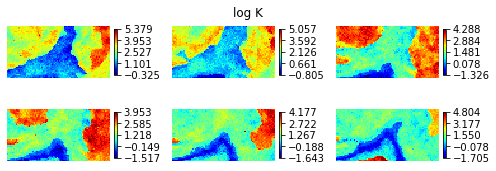

In [ ]:
c_map = x_test[np.random.randint(0, len(x_test),1)[0]]
simple_plot(c_map[0], 'log K')
# len(c_map)

## training part

In [ ]:
os.makedirs("images_CAAE", exist_ok=True)

parser = argparse.ArgumentParser()
parser.add_argument('-f')
parser.add_argument("--current-dir", type=str, default="/content/drive/MyDrive/react_inverse/CAAE/", help="data directory")
parser.add_argument("--n-epochs", type=int, default=50, help="number of epochs of training")
parser.add_argument('--n-train', type=int, default=23000, help='number of training data')
parser.add_argument('--n-test', type=int, default=4000, help='number of training data')
parser.add_argument("--batch-size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--lw", type=float, default=0.01, help="adversarial loss weight")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--sample-interval", type=int, default=10, help="interval between image sampling")
opt = parser.parse_args()
print(opt)

cuda = True if torch.cuda.is_available() else False

date = 'experiments/Feb_14_CAAE3D'
exp_dir = opt.current_dir + date + "/N{}_Bts{}_Eps{}_lr{}_lw{}".\
    format(opt.n_train, opt.batch_size, opt.n_epochs, opt.lr, opt.lw)

output_dir = exp_dir + "/predictions"
model_dir = exp_dir
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# loss functions
adversarial_loss = torch.nn.BCELoss()
pixelwise_loss = torch.nn.L1Loss()

nf, d, h, w = 2, 2, 11, 21

# Initialize generator and discriminator
encoder = Encoder(outchannels=nf)
decoder = Decoder(inchannels=nf)
discriminator = Discriminator(inchannels=nf)

print("number of parameters: {}".format(encoder._n_parameters()+decoder._n_parameters()+discriminator._n_parameters()))

if cuda:
    encoder.cuda()
    decoder.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    pixelwise_loss.cuda()

dataloader, x_test = load_data(opt)

# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


def test(epoch):
    encoder.eval()
    decoder.eval()

    n_samples = 1
    z = Variable(Tensor(np.random.normal(0, 1, (n_samples, nf, d, h, w))))
    gen_imgs = decoder(z)
    samples = np.squeeze(gen_imgs.data.cpu().numpy())
    plot_pred(samples,epoch,0,output_dir)

    idx = np.random.choice(opt.n_test, 1, replace=False)
    real_imgs = x_test[[idx]]
    real_imgs = (torch.FloatTensor(real_imgs)).cuda()
    encoded_imgs = encoder(real_imgs)
    decoded_imgs = decoder(encoded_imgs)
    samples_gen  = np.squeeze(decoded_imgs.data.cpu().numpy())
    samples_real = np.squeeze(real_imgs.data.cpu().numpy())

    samples = np.vstack((samples_real[:3],samples_gen[:3],samples_real[3:],samples_gen[3:]))
    plot_pred(samples,epoch+1,idx,output_dir)

start = time.time()
# ----------
#  Training
# ----------
for epoch in range(1,opt.n_epochs+1):
    encoder.train()
    decoder.train()
    discriminator.train()

    for i, (imgs,) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0],1).fill_(1.0), requires_grad=False)
        fake  = Variable(Tensor(imgs.shape[0],1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        encoded_imgs = encoder(real_imgs)
        decoded_imgs = decoder(encoded_imgs)

        # Loss measures generator's ability to fool the discriminator
        g_loss_a = adversarial_loss(discriminator(encoded_imgs), valid)
        g_loss_c = pixelwise_loss(decoded_imgs, real_imgs)

        g_loss = opt.lw * g_loss_a + g_loss_c

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Sample noise as discriminator ground truth
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], nf, d, h, w))))

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()

    batches_done = epoch * len(dataloader) + i
    if (epoch) % opt.sample_interval == 0:
        test(epoch)

    print(
        "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f /G_A loss: %f/ G_C loss: %f]"
        % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item(), g_loss_a.item(), g_loss_c.item())
    )

torch.save(decoder.state_dict(), model_dir + '/AAE_decoder_epoch{}.pth'.format(opt.n_epochs))
torch.save(encoder.state_dict(), model_dir + '/AAE_encoder_epoch{}.pth'.format(opt.n_epochs))
torch.save(discriminator.state_dict(), model_dir + '/AAE_discriminator_epoch{}.pth'.format(opt.n_epochs))
print('time for training:', time.time()-start)

Namespace(b1=0.5, b2=0.999, batch_size=64, current_dir='/content/drive/MyDrive/react_inverse/CAAE/', f='/root/.local/share/jupyter/runtime/kernel-d04df7a5-6eb7-43d3-b659-8f6ed71a6815.json', lr=0.0002, lw=0.01, n_epochs=50, n_test=4000, n_train=23000, sample_interval=10)
number of parameters: 11823618
Total number of conductivity images: 27048
total training data shape: (23000, 1, 6, 41, 81)
[Epoch 1/50] [Batch 359/360] [D loss: 0.830619] [G loss: 0.385165 /G_A loss: 0.640725/ G_C loss: 0.378758]
[Epoch 2/50] [Batch 359/360] [D loss: 0.662937] [G loss: 0.322533 /G_A loss: 0.855457/ G_C loss: 0.313978]
[Epoch 3/50] [Batch 359/360] [D loss: 0.689949] [G loss: 0.302666 /G_A loss: 0.645077/ G_C loss: 0.296215]
[Epoch 4/50] [Batch 359/360] [D loss: 0.608766] [G loss: 0.336508 /G_A loss: 1.130831/ G_C loss: 0.325200]
[Epoch 5/50] [Batch 359/360] [D loss: 0.629861] [G loss: 0.295878 /G_A loss: 0.819538/ G_C loss: 0.287683]
[Epoch 6/50] [Batch 359/360] [D loss: 0.626531] [G loss: 0.278019 /G_A 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


epoch 11, done printing
[Epoch 10/50] [Batch 359/360] [D loss: 0.689653] [G loss: 0.272549 /G_A loss: 0.661343/ G_C loss: 0.265935]
[Epoch 11/50] [Batch 359/360] [D loss: 0.639167] [G loss: 0.281721 /G_A loss: 1.173022/ G_C loss: 0.269991]
[Epoch 12/50] [Batch 359/360] [D loss: 0.555962] [G loss: 0.270431 /G_A loss: 1.192755/ G_C loss: 0.258504]
[Epoch 13/50] [Batch 359/360] [D loss: 0.562495] [G loss: 0.296917 /G_A loss: 0.948231/ G_C loss: 0.287435]
[Epoch 14/50] [Batch 359/360] [D loss: 0.620493] [G loss: 0.267063 /G_A loss: 0.898006/ G_C loss: 0.258082]
[Epoch 15/50] [Batch 359/360] [D loss: 0.481739] [G loss: 0.266879 /G_A loss: 1.107682/ G_C loss: 0.255803]
[Epoch 16/50] [Batch 359/360] [D loss: 0.475665] [G loss: 0.315295 /G_A loss: 1.265028/ G_C loss: 0.302645]
[Epoch 17/50] [Batch 359/360] [D loss: 0.591780] [G loss: 0.260418 /G_A loss: 0.836854/ G_C loss: 0.252050]
[Epoch 18/50] [Batch 359/360] [D loss: 0.591803] [G loss: 0.271315 /G_A loss: 1.138041/ G_C loss: 0.259935]
[Epo

## Inspecting mu and logvar for the input parameters

In [4]:
cuda = True if torch.cuda.is_available() else False
n_train = 23000
n_test = 100
batch_size = 64
n_epochs = 50
lr = 0.0002 ## adam learning rate
lw = 0.01 ## "adversarial loss weight"

current_dir = "/content/drive/MyDrive/react_inverse/CAAE/"
date = 'experiments/Feb_14_CAAE3D'
exp_dir = current_dir + date + "/N{}_Bts{}_Eps{}_lr{}_lw{}".\
    format(n_train, batch_size, n_epochs, lr, lw)

output_dir = exp_dir + "/predictions"
model_dir = exp_dir

nf, d, h, w = 2, 2, 11, 21

# Initialize generator and discriminator
class Encoder(nn.Module):
    def __init__(self, inchannels=1, outchannels=2, filters=48, num_res_blocks=1):
        super(Encoder, self).__init__()
        # input size, inchannels x 6 x 41 x 81
        self.conv1 = nn.Conv3d(inchannels, filters, kernel_size=3, stride=2, padding=1)
        # state size. filters x 3 x 21 x 41
        self.res_blocks = nn.Sequential(*[ResidualInResidualDenseBlock(filters) for _ in range(num_res_blocks)])
        # state size. filters x 3 x 21 x 41
        self.trans = nn.Sequential(
            nn.BatchNorm3d(filters),
            nn.ReLU(inplace=True),
            nn.Conv3d(filters, filters, kernel_size=3, stride=2, padding=1),
        )
        # state size. filters x 2 x 11 x 21
        self.mu = nn.Conv3d(filters, outchannels, 3, 1, 1, bias=False) #does not change state size.
        self.logvar = nn.Conv3d(filters, outchannels, 3, 1, 1, bias=False) #does not change state size.

    def forward(self, img):
        # img: inchannels x 6 x 41 x 81
        out1 = self.conv1(img)        # filters x 3 x 21 x 41
        out2 = self.res_blocks(out1)   # filters x 3 x 21 x 41
        out3 = self.trans(out2)        # filters x 2 x 11 x 21

        mu, logvar = self.mu(out3), self.logvar(out3)
        z = reparameterization(mu, logvar) # latent dimension: outchannels x 2 x 11 x 21
        # return mu, logvar, z
        return z

    def _n_parameters(self):
        n_params = 0
        for name, param in self.named_parameters():
            n_params += param.numel()
        return n_params

encoder = Encoder(outchannels=nf)
decoder = Decoder(inchannels=nf)
discriminator = Discriminator(inchannels=nf)

encoder.load_state_dict(torch.load(model_dir + '/AAE_encoder_epoch{}.pth'.format(n_epochs)))
decoder.load_state_dict(torch.load(model_dir + '/AAE_decoder_epoch{}.pth'.format(n_epochs)))
discriminator.load_state_dict(torch.load(model_dir + '/AAE_discriminator_epoch{}.pth'.format(n_epochs)))

if cuda:
    encoder.cuda()
    decoder.cuda()
    discriminator.cuda()

encoder.eval()
decoder.eval()
discriminator.eval()

def load_data(n_train, n_test, batch_size):
    with open('/content/drive/MyDrive/react_inverse/training_data/kds.pkl', 'rb') as file:
      kds = np.expand_dims(np.asarray(pk.load(file)), axis=1)
    print('Total number of conductivity images:', len(kds))

    x_train = kds[:n_train]
    x_test = kds[n_train: n_train + n_test]
    print("total training data shape: {}".format(x_train.shape))

    data = torch.utils.data.TensorDataset(torch.FloatTensor(x_train))
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                              shuffle=True, num_workers=int(2))
    return data_loader, x_test

_, x_test = load_data(n_train, n_test, batch_size)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
start = time.time()
# Configure input
real_imgs = Tensor(x_test)
# mu, logvar, encoded_imgs = encoder(real_imgs)
encoded_imgs = encoder(real_imgs)
decoded_imgs = decoder(encoded_imgs)
# Sample noise as discriminator ground truth
z = Variable(Tensor(np.random.normal(0, 1, (real_imgs.shape[0], nf, d, h, w))))
print('time for processing training data:', time.time()-start)

Total number of conductivity images: 27048
total training data shape: (23000, 1, 6, 41, 81)
time for processing training data: 1.4005682468414307


In [5]:
!pip install attrdict
!pip install --upgrade matplotlib

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.7/dist-packages (3.4.1)


In [22]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors
def plot_3d(real, gen, title='', cut=None):
    fig = plt.figure()
    data_all = [real, gen]
    vmin = np.min(np.array(data_all))
    vmax = np.max(np.array(data_all))
    
    v1 = np.linspace(vmin,vmax, 8, endpoint=True)
    i = 1
    for data in data_all:
        data = np.transpose(data, (2, 1, 0))
        data = np.flip(data, axis=2)
        filled = np.ones(data.shape)
        if cut is not None:
            filled[cut[2]:, :cut[1], (6-cut[0]):] = 0
        x, y, z = np.indices(np.array(filled.shape) + 1)
        
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        
        ax = fig.add_subplot(1, 2, i, projection='3d')
        ax.voxels(x, y, z, filled, facecolors=plt.cm.jet(norm(data)), edgecolors=None)
        ax.set_box_aspect([250, 125, 50])
        
        m = cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
        m.set_array([])
        ax.set_axis_off()
        i += 1
    fig.colorbar(m, ax=ax, fraction=0.015, pad=0.04, ticks=v1,)
        
    plt.tight_layout()
    # ax.set_title(title)
    plt.savefig(title+'.pdf',bbox_inches='tight')
    return fig

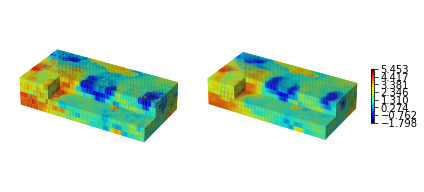

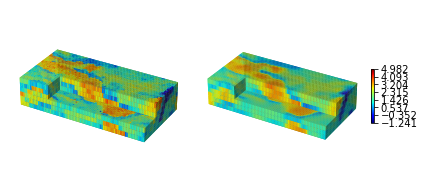

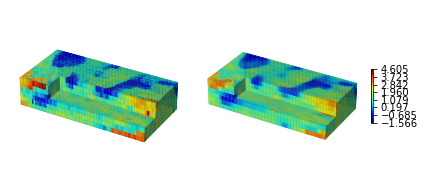

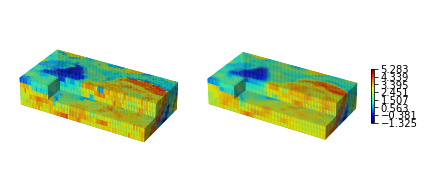

In [27]:
np.random.seed(888)
idxs = np.random.choice(n_test, 4, replace=False)
for idx in idxs:
    real_imgs = x_test[[idx]]
    real_imgs = (torch.FloatTensor(real_imgs)).cuda()
    encoded_imgs = encoder(real_imgs)
    decoded_imgs = decoder(encoded_imgs)
    samples_gen  = np.squeeze(decoded_imgs.data.cpu().numpy())
    samples_real = np.squeeze(real_imgs.data.cpu().numpy())

    # samples = np.vstack((samples_real[:3],samples_gen[:3],samples_real[3:],samples_gen[3:]))
    # plot_pred(samples,n_epochs+1,idx,output_dir)
    plot_3d(samples_real,samples_gen,title=output_dir+'/test_'+str(idx), cut=[3, 12+1, 20-1])

In [ ]:
mu = mu.cpu().detach().numpy()
logvar = logvar.cpu().detach().numpy()
z = z.cpu().detach().numpy()

(924,)


-0.023063863
0.8984412


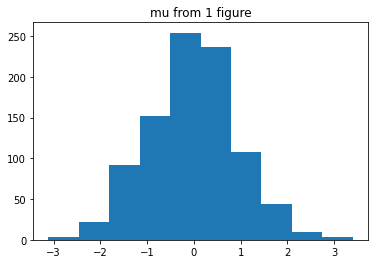

In [ ]:
one_mu = np.reshape(mu[0], (-1,))
plt.hist(one_mu)
plt.title('mu from 1 figure')
print(np.mean(one_mu))
print(np.var(one_mu))

1.3505128e-06
8.166914e-12


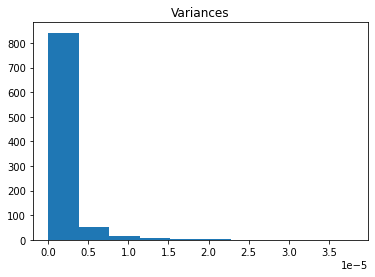

In [ ]:
one_logvar = np.reshape(logvar[0], (-1))
one_varone_var = np.exp(one_logvar)
plt.hist(one_var)
plt.title('Variances')
print(np.mean(one_var))
print(np.var(one_var))